In [8]:
import sys
sys.path.append("..")

from data_transformation.db_env import DbEnv, db

# Native libraries
import os
import math
# Essential Libraries
import pandas as pd
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

ImportError: cannot import name 'abc' from 'bson.py3compat' (C:\ProgramData\Anaconda3\lib\site-packages\bson\py3compat.py)

https://www.kaggle.com/izzettunc/introduction-to-time-series-clustering

# 1.Preprocessing

In [49]:
#get song_num list
# 지수 추가해서 그래프에서 비교 가능하게 해주기, 클러스터링 기준?

conn, cursor = DbEnv().connect_sql()
sql = "SELECT DISTINCT num FROM daily_music_cow"
num_list = DbEnv().get_data_from_table(cursor, sql)
num_list = [item[0] for item in num_list]
print(num_list)

[26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 106, 107, 108, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163, 164, 165, 167, 168, 169, 171, 173, 174, 175, 176, 177, 178, 179, 180, 183, 184, 185, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 198, 199, 202, 204, 206, 207, 208, 211, 212, 216, 218, 219, 221, 224, 225, 230, 231, 233, 237, 238, 240, 258, 261, 262, 265, 267, 274, 311, 322, 345, 373, 382, 420, 460, 461, 462, 464, 465, 466, 467, 468, 469, 470, 471, 472, 474, 475, 477, 478, 479, 480, 481, 482, 483, 484, 485

In [50]:
df_price, df_mcpi = pd.DataFrame(), pd.DataFrame()

# find shortest date length to fit all songs
for num in num_list:
    sql = "SELECT date, price FROM daily_music_cow WHERE num = %s" % num
    df_temp = db(cursor, sql).dataframe
    df_temp = df_temp.set_index('date')
    df_temp.columns = ["%d" % num]

    df_price = pd.concat([df_price, df_temp], axis=1)

print(df_price)
df_price.to_pickle("../storage/df_price.pkl")

               26     27     28     29     30     31     32     33     34  \
date                                                                        
2021-06-03  29000  26000  24000  52800  13500  16100  10300  14500  36400   
2021-06-04  29000  26000  24000  52800  13500  16100  10300  14500  36400   
2021-06-05  29000  26000  23700  52800  13500  16100  10800  14500  36400   
2021-06-06  28500  26000  23500  52800  13500  16100  10800  14500  36400   
2021-06-07  29100  26000  24900  52800  13500  15100  10800  14500  36400   
...           ...    ...    ...    ...    ...    ...    ...    ...    ...   
2021-11-23  29000  43000  29800  90700  19100  70100  15100  37200  40000   
2021-11-24  28500  43000  29900  90700  19100  70000  15000  37200  40000   
2021-11-25  27900  43000  29800  90700  19100  70000  15000  37200  40000   
2021-11-26  30000  43000  31200  90700  19100  70000  15000  37200  40000   
2021-11-27  27000  43000  29100  90700  19000  70000  16100  37200  40000   

In [51]:
sql = "SELECT date, price FROM daily_mcpi"
df_mcpi = db(cursor, sql).dataframe
df_mcpi = df_mcpi.set_index('date')
df_mcpi.columns = [0]

print(df_mcpi)
df_mcpi.to_pickle("../storage/df_mcpi.pkl")

                 0
date              
2021-12-08  246.43
2021-12-07  247.01
2021-12-06  246.48
2021-12-05  246.18
2021-12-04  245.84
...            ...
2019-03-24   83.54
2019-03-23   83.59
2019-03-22   83.44
2019-03-21   82.88
2019-03-20   82.59

[1990 rows x 1 columns]


In [7]:
# 결측치 제거를 통해 date 맞춰주기
df_price = pd.read_pickle('../storage/df_price.pkl')
df_mcpi = pd.read_pickle('../storage/df_mcpi.pkl')

df_price = df_price.reset_index()
df_mcpi = df_mcpi.reset_index()

df_price = pd.merge(df_price, df_mcpi, how='inner', on='date')
df_price = df_price.drop_duplicates()
df_price = df_price.set_index('date')

df_price_droped = df_price.dropna(axis=0)
df_price_droped = df_price_droped.sort_index(ascending=True)
list_price_droped = list(df_price_droped.columns)

print(df_price_droped)

ValueError: unsupported pickle protocol: 5

In [53]:
# MinMaxScaler로 정규화
array_price_scaled = MinMaxScaler().fit_transform(df_price_droped)
df_price_scaled = pd.DataFrame(array_price_scaled)
df_price_scaled.columns = list_price_droped
df_price_scaled.index = df_price_droped.index
print(df_price_scaled)

# num=0(MCPI) 지수 df에서 제거
df_mcpi = df_price_scaled[df_price_scaled.columns[-1]]
df_price_scaled = df_price_scaled.drop(df_price_scaled.columns[-1], axis='columns')
array_price_scaled = np.delete(array_price_scaled, -1, 1)

print(df_mcpi)

                  26        27        28        29        30        31  \
date                                                                     
2021-07-06  0.018939  0.197015  0.067797  0.159490  0.063348  0.021299   
2021-07-07  0.018939  0.197015  0.067797  0.159490  0.063348  0.021299   
2021-07-08  0.018939  0.197015  0.067797  0.159490  0.063348  0.021299   
2021-07-09  0.015152  0.197015  0.033898  0.159490  0.063348  0.021299   
2021-07-10  0.011364  0.017910  0.000000  0.159490  0.063348  0.021299   
...              ...       ...       ...       ...       ...       ...   
2021-11-23  0.208333  0.794030  0.372881  0.400319  0.156863  0.271169   
2021-11-24  0.189394  0.794030  0.375706  0.400319  0.156863  0.270649   
2021-11-25  0.166667  0.794030  0.372881  0.400319  0.156863  0.270649   
2021-11-26  0.246212  0.794030  0.412429  0.400319  0.156863  0.270649   
2021-11-27  0.132576  0.794030  0.353107  0.400319  0.155354  0.270649   

                  32        33       

# 2. Clustering

In [54]:
array_price_scaled_t = np.transpose(array_price_scaled)

print(df_mcpi)

date
2021-07-06    0.033448
2021-07-07    0.032253
2021-07-08    0.026280
2021-07-09    0.023344
2021-07-10    0.026828
                ...   
2021-11-23    0.320741
2021-11-24    0.315714
2021-11-25    0.314469
2021-11-26    0.299587
2021-11-27    0.305560
Name: 0, Length: 145, dtype: float64


## (1) SOM raw data

In [55]:
som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(array_price_scaled_t))))


som = MiniSom(som_x, som_y,len(array_price_scaled_t[0]), sigma=0.3, learning_rate=0.1)

som.random_weights_init(array_price_scaled_t)
som.train(array_price_scaled_t, 50000)

In [56]:
def plot_som_series_averaged_center(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(df_mcpi, c="red")
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="blue")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

In [94]:
def plot_som_series_averaged_center_without_index(som_x, som_y, win_map):
    fig, axs = plt.subplots(som_x,som_y,figsize=(25,25))
    fig.suptitle('Clusters')
    for x in range(som_x):
        for y in range(som_y):
            cluster = (x,y)
            if cluster in win_map.keys():
                for series in win_map[cluster]:
                    axs[cluster].plot(series,c="gray",alpha=0.5) 
                axs[cluster].plot(np.average(np.vstack(win_map[cluster]),axis=0),c="blue")
            cluster_number = x*som_y+y+1
            axs[cluster].set_title(f"Cluster {cluster_number}")

    plt.show()

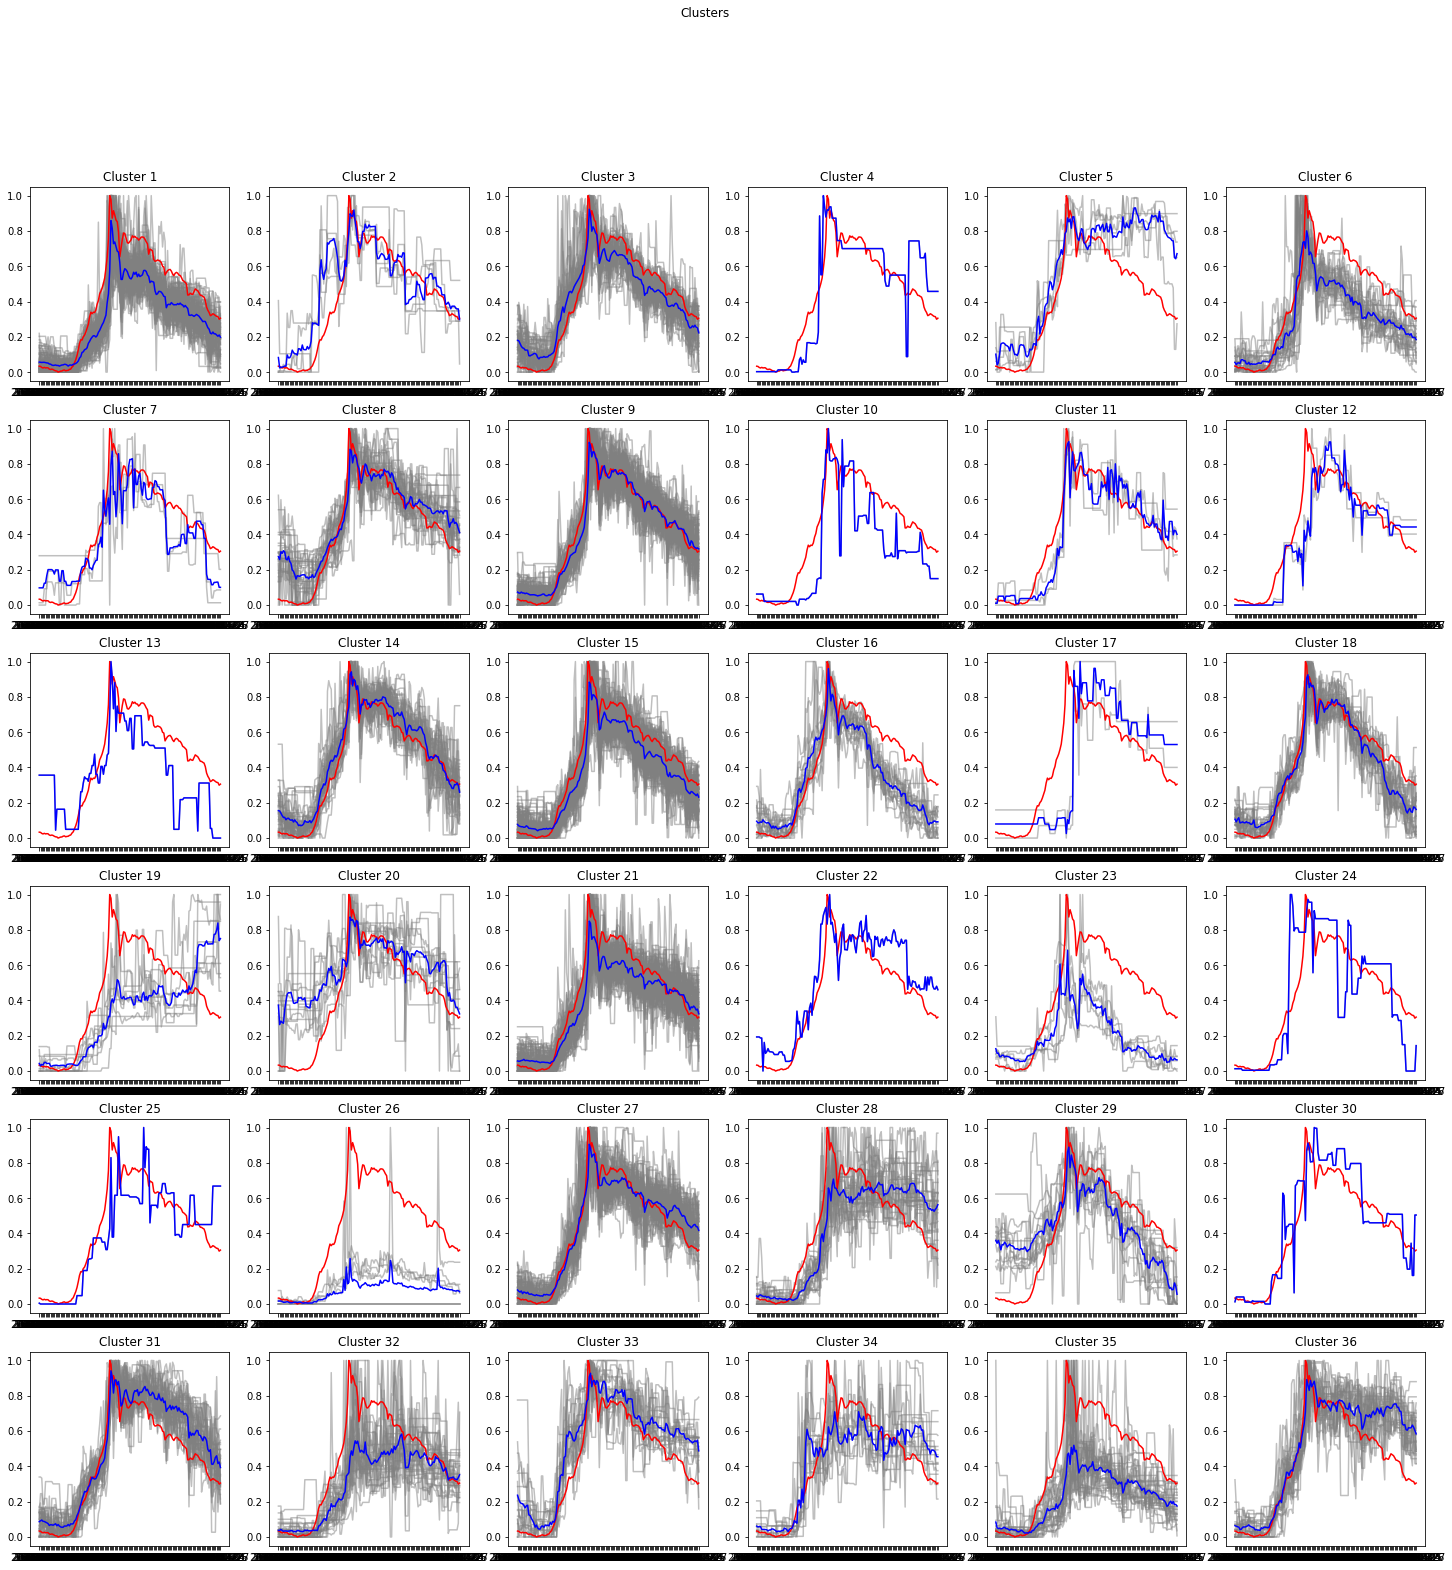

In [57]:
win_map = som.win_map(array_price_scaled_t)

plot_som_series_averaged_center(som_x, som_y, win_map)

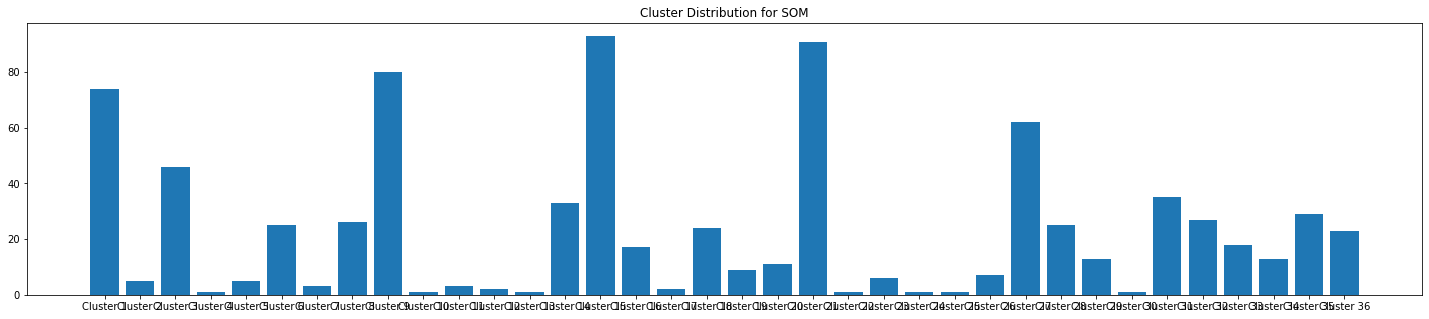

In [58]:
cluster_c = []
cluster_n = []
for x in range(som_x):
    for y in range(som_y):
        cluster = (x,y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x*som_y+y+1
        cluster_n.append(f"Cluster {cluster_number}")

plt.figure(figsize=(25,5))
plt.title("Cluster Distribution for SOM")
plt.bar(cluster_n,cluster_c)
plt.show()

<br>시계열이 시각적으로도 잘 구분을 못함<br/>
<br>위아래로의 등락이 너무 Chaotic하기 때문이라고 판단.<br/>
<br>특히 뮤직카우의 경우 유동성이 충분하지 않기 때문에 적절한 균형가격에 Optimize되지 않는 문제<br/>
<br>Smoothing을 통해 다시 분류<br/>

 # (2) SOM holtwinters weight 0.3

In [59]:
#smoothing 0.3
array_price = df_price_droped.to_numpy()
array_price_t = np.transpose(array_price)

from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt

array_price_smooth03_t = np.empty((0, 145))

for x in array_price_t:
    model_smooth = SimpleExpSmoothing(x)
    fit_smooth = model_smooth.fit(smoothing_level=.3)
    array_price_smooth03_t = np.append(array_price_smooth03_t, fit_smooth.fittedvalues.reshape(1, 145), axis=0)

print(array_price_smooth03_t)

C:\Users\abocado\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\abocado\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1439: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
C:\Users\abocado\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1445: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)


[[23972.15089044 23980.50562331 23986.35393632 ... 29986.60988338
  29360.62691837 29552.43884286]
 [21546.5843449  21982.60904143 22287.826329   ... 42027.55423518
  42319.28796463 42523.50157524]
 [19085.28502954 19059.69952068 19041.78966447 ... 29922.25987131
  29885.58190992 30279.90733694]
 ...
 [15656.82003344 15789.77402341 15642.84181639 ... 15048.76524449
  15214.13567115 15329.8949698 ]
 [10820.79085584 10934.55359909 10984.18751936 ... 16094.39608156
  15766.07725709 15536.25407996]
 [  188.31108024   188.61075617   188.74852932 ...   248.43254643
    247.6337825    246.17764775]]


In [60]:
# MinMaxScaler로 정규화
array_price_smooth03 = np.transpose(array_price_smooth03_t)
array_price_smooth03_scaled = MinMaxScaler().fit_transform(array_price_smooth03)
df_price_smooth03_scaled = pd.DataFrame(array_price_smooth03_scaled)
df_price_smooth03_scaled.columns = list_price_droped
df_price_smooth03_scaled.index = df_price_droped.index
print(df_price_smooth03_scaled)

# num=0(MCPI) 지수 df에서 제거
df_mcpi_smooth03_scaled = df_price_smooth03_scaled[df_price_smooth03_scaled.columns[-1]]
df_price_smooth03_scaled = df_price_smooth03_scaled.drop(df_price_smooth03_scaled.columns[-1], axis='columns')
array_price_smooth03_scaled = np.delete(array_price_smooth03_scaled, -1, 1)

print(df_mcpi_smooth03_scaled)

                  26        27        28        29        30        31  \
date                                                                     
2021-07-06  0.013364  0.171622  0.034856  0.160258  0.068265  0.030995   
2021-07-07  0.013790  0.186233  0.034001  0.160258  0.068627  0.030995   
2021-07-08  0.014087  0.196460  0.033403  0.160258  0.068880  0.030995   
2021-07-09  0.014296  0.203620  0.032984  0.160258  0.069057  0.030995   
2021-07-10  0.012914  0.208631  0.020659  0.160258  0.069182  0.030995   
...              ...       ...       ...       ...       ...       ...   
2021-11-23  0.387396  0.824013  0.399246  0.497317  0.241882  0.549047   
2021-11-24  0.351972  0.843964  0.397358  0.492190  0.228365  0.537184   
2021-11-25  0.319538  0.857929  0.397039  0.488600  0.218903  0.528581   
2021-11-26  0.287672  0.867705  0.395813  0.486088  0.212280  0.522559   
2021-11-27  0.297436  0.874548  0.408992  0.484329  0.207644  0.518344   

                  32        33       

In [61]:
array_price_smooth03_scaled_t = np.transpose(array_price_smooth03_scaled)

som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(array_price_smooth03_scaled_t))))


som = MiniSom(som_x, som_y,len(array_price_smooth03_scaled_t[0]), sigma=0.3, learning_rate=0.1)

som.random_weights_init(array_price_smooth03_scaled_t)
som.train(array_price_smooth03_scaled_t, 50000)

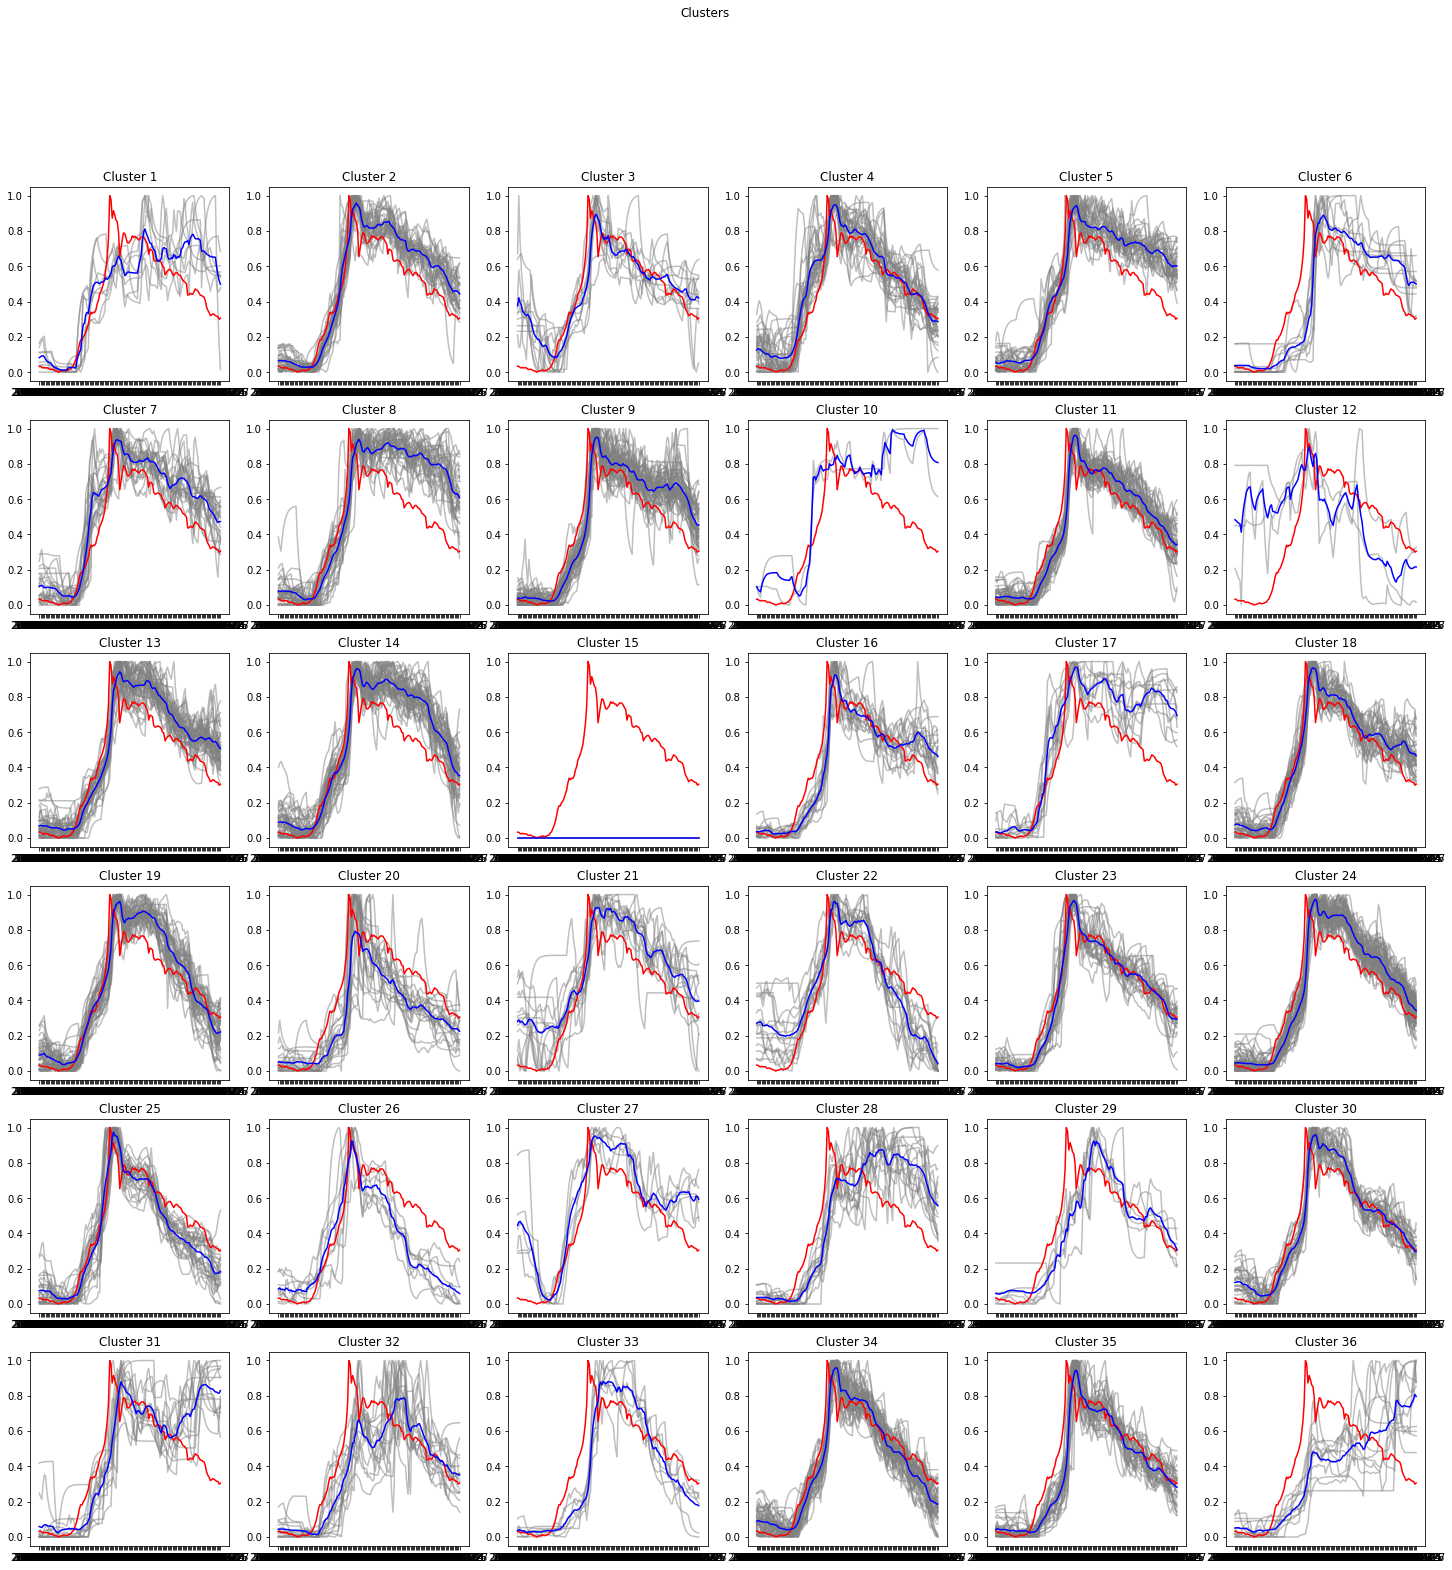

In [62]:
win_map = som.win_map(array_price_smooth03_scaled_t)

plot_som_series_averaged_center(som_x, som_y, win_map)

## (3) SOM holtwinters weight 0.5

In [65]:
#smoothing 0.5
array_price_smooth05_t = np.empty((0, 145))

for x in array_price_t:
    model_smooth = SimpleExpSmoothing(x)
    fit_smooth = model_smooth.fit(smoothing_level=.5)
    array_price_smooth05_t = np.append(array_price_smooth05_t, fit_smooth.fittedvalues.reshape(1, 145), axis=0)
print(array_price_smooth05_t)

C:\Users\abocado\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\abocado\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1439: RuntimeWarning: divide by zero encountered in log
  aic = self.nobs * np.log(sse / self.nobs) + k * 2
C:\Users\abocado\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:1445: RuntimeWarning: divide by zero encountered in log
  bic = self.nobs * np.log(sse / self.nobs) + k * np.log(self.nobs)


[[23984.19241918 23992.09620959 23996.0481048  ... 29112.59174353
  28506.29587176 29253.14793588]
 [22623.80397027 22811.90198514 22905.95099257 ... 42745.6039522
  42872.8019761  42936.40098805]
 [18924.20776106 18962.10388053 18981.05194027 ... 29864.50015109
  29832.25007555 30516.12503777]
 ...
 [15804.38095944 15952.19047972 15626.09523986 ... 14738.05845619
  15169.02922809 15384.51461405]
 [11019.49060818 11109.74530409 11104.87265204 ... 16235.25778096
  15617.62889048 15308.81444524]
 [  188.83586277   189.07293138   189.07146569 ...   246.92026265
    246.34513132   244.56256566]]


In [66]:
# MinMaxScaler로 정규화
array_price_smooth05 = np.transpose(array_price_smooth05_t)
array_price_smooth05_scaled = MinMaxScaler().fit_transform(array_price_smooth05)
df_price_smooth05_scaled = pd.DataFrame(array_price_smooth05_scaled)
df_price_smooth05_scaled.columns = list_price_droped
df_price_smooth05_scaled.index = df_price_droped.index
print(df_price_smooth05_scaled)

# num=0(MCPI) 지수 df에서 제거
df_mcpi_smooth05_scaled = df_price_smooth05_scaled[df_price_smooth05_scaled.columns[-1]]
df_price_smooth05_scaled = df_price_smooth05_scaled.drop(df_price_smooth05_scaled.columns[-1], axis='columns')
array_price_smooth05_scaled = np.delete(array_price_smooth05_scaled, -1, 1)


print(df_mcpi_smooth05_scaled)

                  26        27        28        29        30        31  \
date                                                                     
2021-07-06  0.015141  0.205064  0.044565  0.162542  0.068834  0.033210   
2021-07-07  0.015499  0.211262  0.045749  0.162542  0.068834  0.033210   
2021-07-08  0.015678  0.214361  0.046341  0.162542  0.068834  0.033210   
2021-07-09  0.015768  0.215910  0.046637  0.162542  0.068834  0.033210   
2021-07-10  0.013549  0.216685  0.028041  0.162542  0.068834  0.033210   
...              ...       ...       ...       ...       ...       ...   
2021-11-23  0.307851  0.842933  0.386128  0.461437  0.208363  0.455194   
2021-11-24  0.275023  0.859698  0.385222  0.460393  0.192267  0.451995   
2021-11-25  0.247293  0.868080  0.386331  0.459870  0.184219  0.449963   
2021-11-26  0.219847  0.872271  0.385323  0.459609  0.180195  0.448947   
2021-11-27  0.253655  0.874367  0.406687  0.459479  0.178183  0.448439   

                  32        33       

In [67]:
array_price_smooth05_scaled_t = np.transpose(array_price_smooth05_scaled)

som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(array_price_smooth05_scaled_t))))


som = MiniSom(som_x, som_y,len(array_price_smooth05_scaled_t[0]), sigma=0.3, learning_rate=0.1)

som.random_weights_init(array_price_smooth05_scaled_t)
som.train(array_price_smooth05_scaled_t, 50000)

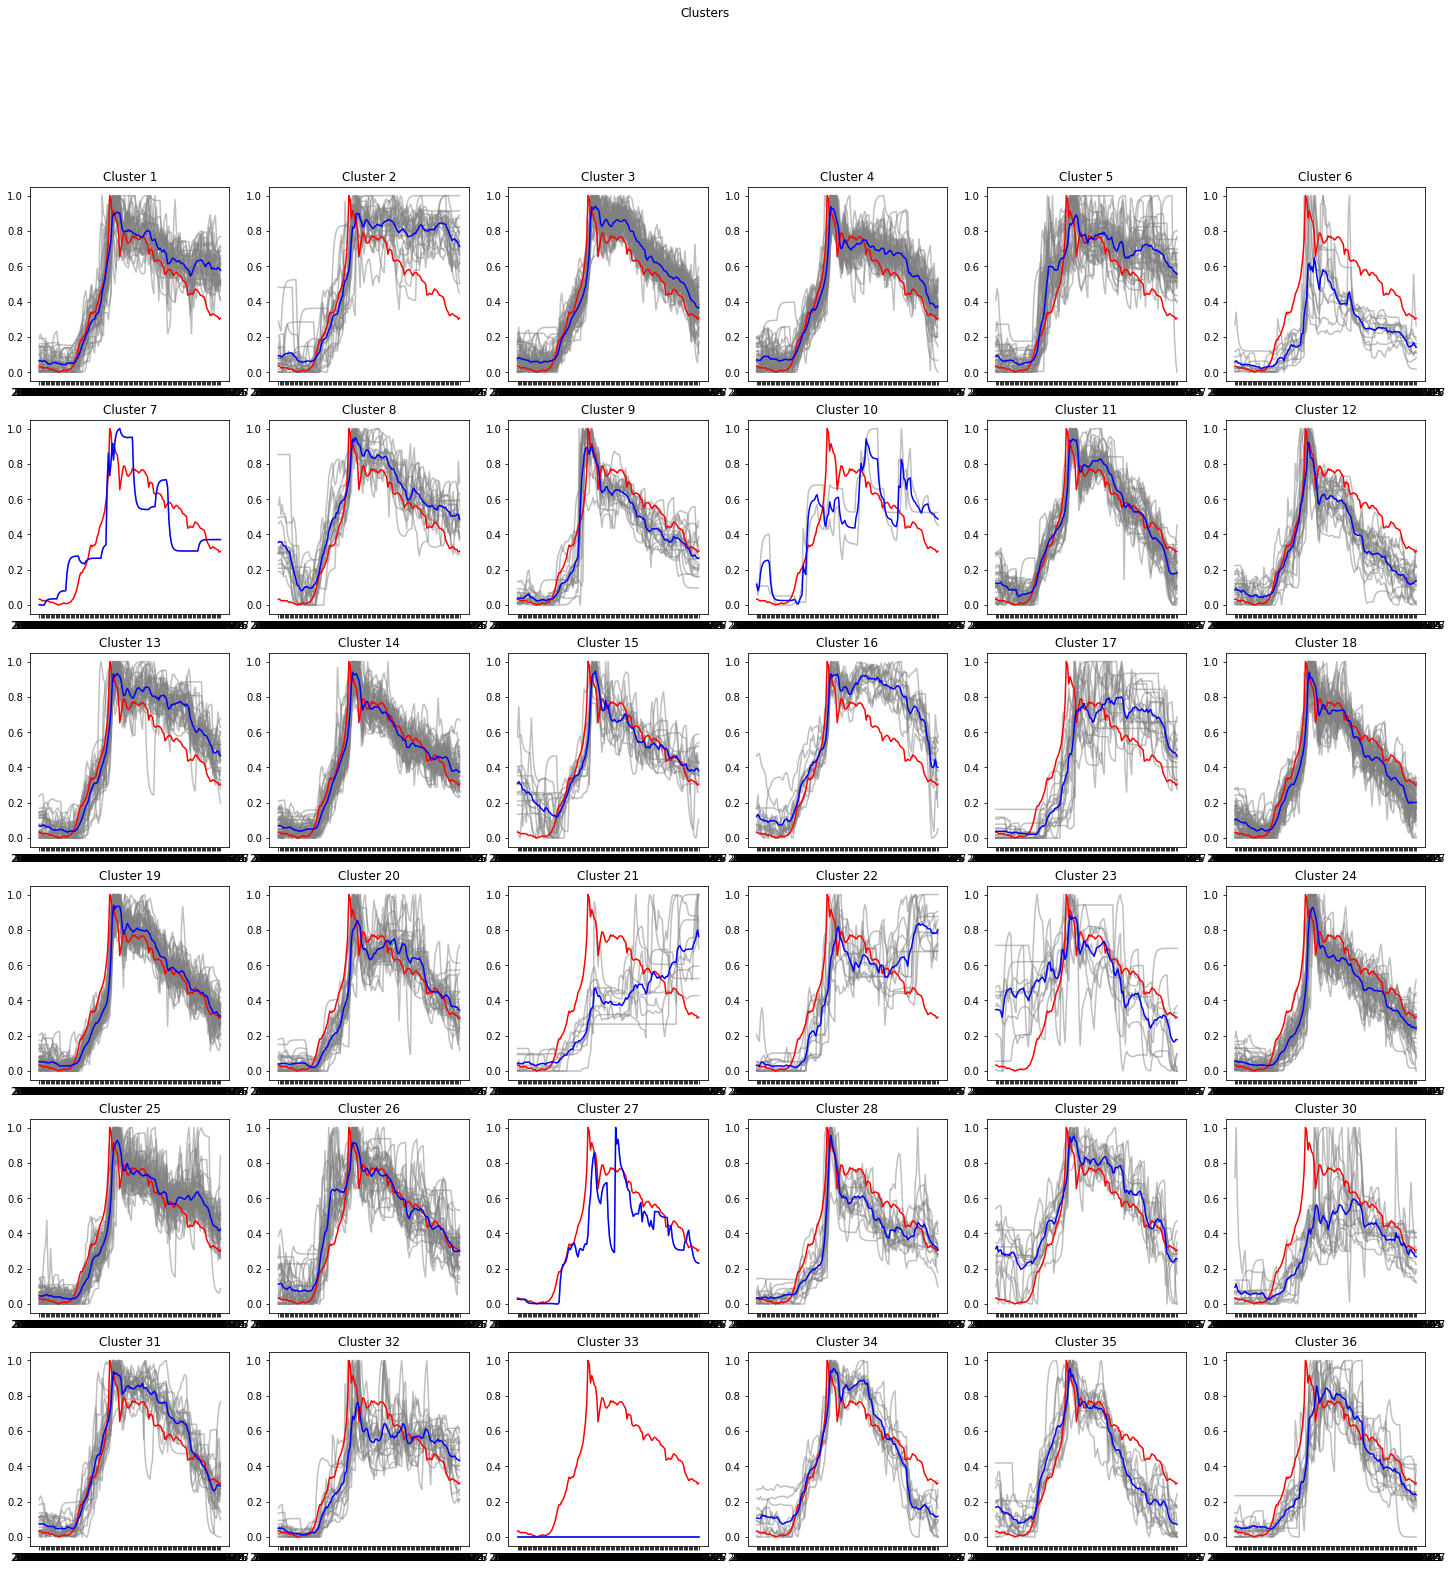

In [68]:
win_map = som.win_map(array_price_smooth05_scaled_t)

plot_som_series_averaged_center(som_x, som_y, win_map)

In [69]:
cluster_map = []
for idx in range(len(array_price_smooth05_scaled_t)):
    winner_node = som.winner(array_price_smooth05_scaled_t[idx])
    cluster_map.append((list_price_droped[idx],f"Cluster {winner_node[0]*som_y+winner_node[1]+1}"))

df_cluster = pd.DataFrame(cluster_map,columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

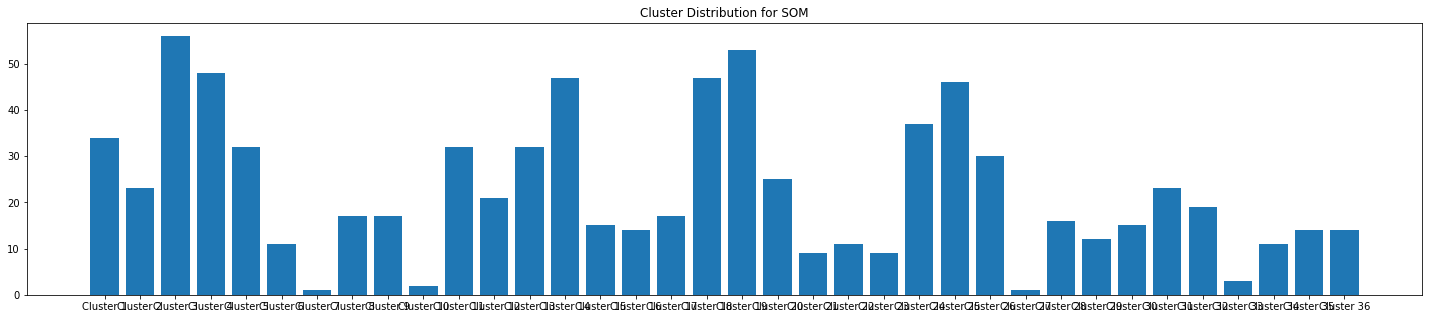

In [70]:
cluster_c = []
cluster_n = []
for x in range(som_x):
    for y in range(som_y):
        cluster = (x,y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x*som_y+y+1
        cluster_n.append(f"Cluster {cluster_number}")

plt.figure(figsize=(25,5))
plt.title("Cluster Distribution for SOM")
plt.bar(cluster_n,cluster_c)
plt.show()

시계열에서 MCPI 효과 제거할 것

In [71]:
conn = DbEnv().connect_mongo('music_cow', 'daily_music_cow')

In [72]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 1"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['1063', '775', '610', '106', '65', '757', '751', '748', '171', '158', '1049', '744', '144', '85', '123', '88', '1108', '95', '1115', '98', '821', '620', '103', '345', '1438', '1542', '467', '1511', '859', '484', '44', '527', '516', '46']
title: 왜그래 --- artist: 김현철
title: Think About' Chu --- artist: 샘김
title: 얘가 이렇게 예뻤나 --- artist: 훈스
title: 별의 별 --- artist: Apink
title: 이상하다 참 --- artist: 민아
title: 그 끝에 그대 --- artist: 청하
title: 내 안부 --- artist: 이우
title: 슬픈 사랑 --- artist: 기호
title: 동화 같은 사랑 --- artist: Apink
title: I'm In Love --- artist: 시크릿
title: Mazeltov --- artist: 제국의아이들
title: 약속 --- artist: 제로
title: Lay Back --- artist: 케이윌
title: Again --- artist: 스페이스 에이
title: Beautiful Target --- artist: B1A4
title: 낡은 그리움 --- artist: 에일리
title: 눈이 내린다 --- artist: god
title: Darling --- artist: 걸스데이
title: 너의 가슴으로 가는 길 --- artist: 먼데이 키즈
title: 서커스 --- artist: MC몽
title: 반짝반짝 --- artist: BIGBANG
title: 영원한 사랑 --- artist: 핑클
title: I Love U Oh Thank U --- artist: MC몽
title: 동네한바퀴 --- arti

In [73]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 2"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['835', '1368', '1048', '382', '154', '723', '43', '42', '630', '27', '489', '507', '1087', '962', '86', '1259', '190', '180', '702', '705', '689', '496', '753']
title: 당신의 눈물 --- artist: 태진아
title: A Fool Moon Night --- artist: 칵스
title: 편한 사람이 생겼어 --- artist: 일락
title: 향수 --- artist: 케이윌
title: 팔베개 --- artist: 소유
title: 겨울이야기 --- artist: 조관우
title: 하이힐 --- artist: 박혜경
title: 안녕 --- artist: 박혜경
title: 눈 내리는 마을 --- artist: 애프터스쿨
title: 연애시대 --- artist: 이승기
title: 미리 메리 크리스마스 --- artist: 아이유
title: 나 이런 여자예요 --- artist: 지아
title: 위로 --- artist: 김범수
title: 사랑은 언제나 목마르다 --- artist: 유미
title: 보란듯이 --- artist: 손승연
title: haaAakkKKK!!! --- artist: OurR
title: 첫 눈 그리고 첫 키스 --- artist: 다니엘
title: 나는... --- artist: MC몽
title: Perhaps Love --- artist: 에릭남
title: 한번만... --- artist: 혜령
title: Too Love --- artist: XIA
title: 내 사랑 --- artist: 이하이
title: 우연히 봄 --- artist: 로꼬


In [74]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 3"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['669', '464', '760', '606', '709', '112', '1238', '1230', '114', '1427', '573', '1103', '727', '988', '1094', '1369', '161', '715', '127', '623', '1356', '971', '565', '1350', '1000', '964', '1344', '638', '923', '651', '71', '1387', '1162', '520', '151', '846', '841', '1176', '1181', '1151', '823', '722', '1221', '530', '1381', '1188', '1059', '582', '644', '1068', '540', '1011', '907', '1066', '902', '783']
title: 날 그만 잊어요 --- artist: 거미
title: 톡톡 --- artist: 마이티 마우스
title: 난 예술이야 --- artist: 헬로비너스
title: 축가 --- artist: 전우성
title: 이 별 --- artist: 길구봉구
title: 눈물 --- artist: 리쌍
title: 난 좋아 --- artist: 정준일
title: 너에게 --- artist: 노리플라이
title: 반창고 --- artist: 허각
title: 알아요 --- artist: 양파
title: I See you --- artist: 강민혁
title: 떠나지마요 --- artist: 더 크로스
title: 넌 또 다른 나 --- artist: 이승철
title: 투게더 --- artist: DJ DOC
title: 혼자만 하는 사랑 --- artist: 거미
title: 원더우먼 --- artist: 씨야
title: 천하무적 --- artist: MC몽
title: 약속 --- artist: 김범수
title: 도망가자 --- artist: MC몽
title: 사랑하는 너에게 --- artist: 젝스키스
title

In [75]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 4"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['716', '719', '721', '487', '1013', '146', '648', '82', '730', '731', '1017', '133', '189', '567', '847', '523', '1023', '745', '558', '64', '176', '622', '1054', '820', '80', '79', '905', '691', '211', '687', '982', '994', '92', '1090', '949', '583', '969', '468', '932', '104', '919', '471', '987', '996', '661', '472', '666', '686']
title: 숙녀에게 --- artist: 변진섭
title: 내게 남은 사랑을 드릴께요 --- artist: 장혜리
title: 휴식같은 친구 --- artist: 김민우
title: 나를 사랑했던 사람아 --- artist: 허각
title: 울어 --- artist: V.O.S
title: 아무도 모르게 --- artist: 치타
title: 진절머리 --- artist: 빈지노
title: 나를 잊지 말아요 --- artist: 허각
title: 별의 이야기 --- artist: 조관우
title: 가까이 와봐 --- artist: 이승철
title: 행복해 --- artist: 애즈원
title: 사람냄새 --- artist: 정인
title: Good Boy --- artist: 백지영
title: 각 --- artist: 황치열
title: 미안해요 --- artist: 거미
title: OOH-AHH하게 --- artist: TWICE
title: 있다 없으니까 --- artist: 씨스타19
title: 애련 --- artist: 컨츄리 꼬꼬
title: 덜덜덜 --- artist: EXID
title: 심상치 않아 --- artist: 키썸
title: 죽을만큼 아파서 Part.2 --- artist: MC몽
title: 커플 --- artist: 젝

In [76]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 5"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['52', '554', '69', '51', '1556', '659', '54', '614', '607', '698', '45', '57', '655', '62', '764', '233', '1076', '125', '961', '135', '466', '934', '475', '486', '1074', '143', '207', '1184', '547', '148', '153', '531']
title: 바질 --- artist: 매드클라운
title: FM --- artist: 크레용팝
title: 너만 봐 --- artist: 유지
title: 화 --- artist: 매드클라운
title: Hello --- artist: 소향
title: 뒷모습이 참 예뻤구나 --- artist: 규현
title: Rap Star --- artist: 스윙스
title: Would You... --- artist: 박지훈
title: 까르보나라 --- artist: 김나희
title: 어른병 --- artist: 황치열
title: Dream --- artist: 수지
title: 꽃 --- artist: 매드클라운
title: 바다 끝 --- artist: 최백호
title: 예쁜 나이 25살 --- artist: 송지은
title: 남잔 다 그래 --- artist: 이우상
title: 예쁜 속옷 --- artist: 지나
title: 하늘색 풍선 --- artist: god
title: 죽도록 사랑해 --- artist: MC몽
title: 술 한잔 해요 --- artist: 지아
title: 나도 여자예요 --- artist: 민아
title: 나쁜놈 --- artist: 마이티 마우스
title: Say --- artist: 젝스키스
title: Nothing Without You --- artist: Wanna One
title: Fiction --- artist: 비스트
title: 빗물이 내려서 --- artist: 김태우
title: 마음 단단히 먹어 

In [77]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 6"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['74', '596', '697', '813', '1018', '710', '909', '84', '191', '1070', '513']
title: 사랑이라 쓰고 아픔이라 부른다 --- artist: 서인영
title: 애모 --- artist: 김수희
title: D-Day --- artist: 정기고
title: BABY DON'T CRY --- artist: 대성
title: Peek-A-Boo --- artist: 박규리
title: Fighter --- artist: 몬스타엑스
title: 아미가르 레스토랑 --- artist: 쎄쎄쎄
title: 슬픔을 참는 세 가지 방법 --- artist: 혜령
title: 진통제 --- artist: 티아라
title: WE LIKE 2 PARTY --- artist: BIGBANG
title: 사랑할래 --- artist: 별


In [78]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 7"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['34']
title: 어머니의 된장국 --- artist: 다이나믹 듀오


In [79]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 8"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['673', '604', '128', '680', '995', '1027', '657', '267', '116', '904', '894', '880', '500', '1170', '840', '1343', '831']
title: Break Away --- artist: 빅마마
title: Feeling --- artist: 정세운
title: 아이스크림 --- artist: MC몽
title: 돌아보지마 --- artist: 이진혁
title: 한눈 팔지마! --- artist: 걸스데이
title: 빙글빙글 --- artist: 유키스
title: 그게 좋은거야 --- artist: 규현
title: 노래 불러줘요 --- artist: god
title: 맘마미아 --- artist: 카라
title: 파라다이스 --- artist: 김재환
title: 바람아 --- artist: Lim Kim
title: 어린애 --- artist: NATURE
title: Blue Eyes --- artist: 쿨
title: 궁금's --- artist: 하성운
title: 내 생애 가장 행복한 시간 PART.2 --- artist: MC몽
title: 힙합 뮤직 --- artist: 주석
title: Zzz --- artist: 김재환


In [80]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 9"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['765', '759', '155', '68', '553', '1016', '612', '1006', '1007', '746', '1421', '871', '1440', '117', '193', '524', '70']
title: 처음사랑 --- artist: 유열
title: 러브 델루나 --- artist: 태용
title: 목소리 --- artist: 백지영
title: White Day --- artist: 걸스데이
title: 왠지 --- artist: DIA
title: Boo --- artist: 아이유
title: 다시 쓰고 싶어 --- artist: 에일리
title: 괜찮을까 --- artist: 박보람
title: 넌 is 뭔들 --- artist: 마마무
title: 첫사랑 --- artist: 오투포
title: Something --- artist: 강다니엘
title: 얼음꽃 --- artist: 에일리
title: 오늘밤은 어둠이 무서워요 --- artist: 10cm
title: 너나 잘해 --- artist: 에일리
title: 넌 달라 --- artist: DIA
title: 노래가 늘었어 --- artist: 에일리
title: If You --- artist: 에일리


In [81]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 10"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['177', '221']
title: 호러쇼 --- artist: MC몽
title: 바람의 유령 --- artist: 제국의아이들


In [82]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 11"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['878', '99', '499', '737', '579', '129', '1105', '124', '869', '568', '892', '889', '1104', '584', '1128', '1102', '37', '1186', '952', '953', '536', '537', '974', '1506', '770', '998', '983', '624', '766', '839', '1038', '1044']
title: 그대 --- artist: 황치열
title: Something --- artist: 걸스데이
title: 꽃이야 --- artist: JBJ
title: 365일 --- artist: 알리
title: 오직 하나뿐인 그대 --- artist: 심신
title: 미운오리새끼 --- artist: god
title: 당신을 위하여 --- artist: 더 크로스
title: 하늘색 약속 --- artist: god
title: 그대가 내 안에 박혔다 --- artist: 황치열
title: 고래의 꿈 --- artist: 바비 킴
title: HONEY BEE --- artist: 루나
title: 미스터리 --- artist: 박지윤
title: 백설공주를 사랑한 난장이 --- artist: 더 크로스
title: 떠날거야 --- artist: 쎄쎄쎄
title: 아직 너의 시간에 살아 --- artist: 이수현
title: Don't Cry --- artist: 더 크로스
title: Happy Birthday --- artist: 라디
title: 니가 참 좋아 --- artist: 10CM
title: 긴 생머리 그녀 --- artist: 틴탑
title: After Party --- artist: 김재환
title: Mr. Potter --- artist: DIA
title: 그 남잔 말야 --- artist: 엠씨더맥스
title: 라밤바 --- artist: 정미애
title: 행복 --- artist: 소란
title: FOR 

In [83]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 12"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['910', '183', '1107', '836', '879', '238', '1014', '1012', '872', '1558', '1172', '1191', '683', '615', '1380', '703', '1428', '1160', '1545', '1540', '1551']
title: 오.꼭.말 --- artist: 하성운
title: PIPPI --- artist: 투아이즈
title: 나의 모든 날 --- artist: 세정
title: 그대 내 친구여 --- artist: 패티김
title: TONIGHT --- artist: BIGBANG
title: 보고싶어 --- artist: 걸스데이
title: EVERYDAY I LOVE YOU --- artist: 이달의소녀
title: 짧은 치마 --- artist: AOA
title: 밤이 두려워진 건 --- artist: 정동하
title: 돌아버리겠네 --- artist: 아웃렛
title: 좋은 이별이 있을 리가 없잖아 --- artist: MC몽
title: 물망초 --- artist: MC몽
title: Blue Rain --- artist: 핑클
title: 제자리 걸음 --- artist: 고유진
title: 이별자리 --- artist: 이우
title: 슬픈다짐 --- artist: 야다
title: Sad --- artist: 손승연
title: 흩어진 나날들 --- artist: 강수지
title: 이별에 아파하기 싫어 --- artist: 백지영
title: 보통 같으면 --- artist: 한동근
title: 너를 --- artist: 이우


In [84]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 13"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['1060', '564', '156', '163', '492', '511', '1121', '993', '992', '653', '948', '480', '968', '616', '230', '147', '262', '1423', '925', '532', '373', '642', '39', '955', '656', '577', '1117', '1109', '94', '712', '587', '1080']
title: 하이힐 --- artist: 브레이브걸스
title: True Colors --- artist: JBJ
title: 블랙홀 --- artist: MC몽
title: 권태중독 --- artist: MC몽
title: Beautiful --- artist: Crush
title: 봄처럼 --- artist: 김보경
title: 내 꿈이여 --- artist: 엠투엠
title: 반짝반짝 --- artist: 걸스데이
title: 입영열차안에서 --- artist: 김민우
title: 왜 이제야 왔니 --- artist: 정엽
title: 그리워하다 --- artist: 비투비
title: 오늘부터 1일 --- artist: 케이윌
title: Ma Boy --- artist: 씨스타19
title: 쇼크 --- artist: 구피
title: 어마어마해 --- artist: 모모랜드
title: 처음 느껴본 이별 --- artist: 정은지
title: Marry Me --- artist: 케이윌
title: 농담 반 진담 반 --- artist: 슈가볼
title: ONE&ONLY --- artist: ASTRO
title: 살찐 사랑 --- artist: 제시
title: 내가 갈게 --- artist: 울랄라세션
title: Profile --- artist: 빈지노
title: 아버지 --- artist: 다이나믹 듀오
title: 어쩌다 --- artist: 브라운아이드걸스
title: You Are My Lady --- artist: 정엽

In [85]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 14"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['621', '1127', '89', '535', '618', '1156', '1388', '218', '963', '1382', '538', '977', '771', '585', '1065', '461', '1111', '884', '1550', '866', '863', '107', '488', '861', '896', '625', '482', '858', '1541', '474', '849', '845', '1507', '544', '707', '713', '1032', '752', '179', '73', '160', '1187', '678', '1055', '741', '141', '1075']
title: 게임의 법칙 --- artist: 구피
title: 나도 모르는 노래 --- artist: 김필
title: Paradise --- artist: 효린
title: BOOMERANG --- artist: Wanna One
title: Com' Back --- artist: 젝스키스
title: 가려진 시간 사이로 --- artist: 윤상
title: 서울 --- artist: 쏜애플
title: 사랑 앞에서 --- artist: 정은지
title: 그남자 --- artist: 현빈
title: 좋다 --- artist: 데이브레이크
title: 죽을 것만 같아 --- artist: 환희
title: 일기장 --- artist: 이승철
title: 갈 수가 없어 --- artist: 벤
title: 그대 슬픔까지 사랑해 --- artist: 심신
title: 눈물에 얼굴을 묻는다 --- artist: 장나라
title: U & I --- artist: 에일리
title: Reason --- artist: 바비 킴
title: ECLIPSE --- artist: GOT7
title: 그 길에 --- artist: 임한별
title: 노래 --- artist: Zion.T
title: Stay Together --- artist: 2NE1
title: 

In [86]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 15"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['1116', '897', '261', '700', '96', '130', '140', '729', '1123', '560', '959', '1101', '957', '958', '132']
title: 조강지처클럽 3 --- artist: 이루
title: 잘 지내 --- artist: 자이언트핑크
title: 혼자가 편해졌어 --- artist: ELSIE
title: Young 20 --- artist: 박지훈
title: Loving U --- artist: 씨스타
title: 전쟁이야 --- artist: 엠블랙
title: 잠꼬대 --- artist: 뉴이스트
title: Only You --- artist: 바비 킴
title: Lonely --- artist: 윤하
title: Twilight --- artist: Wanna One
title: 문득 --- artist: 하성운
title: 밤 끝없는 밤 --- artist: AKMU
title: Lonely Night --- artist: 하성운
title: 잊지마요 --- artist: 하성운
title: 웃픈 하루 --- artist: god


In [87]:
list_cluster = df_cluster[df_cluster.Cluster == "Cluster 16"].index.tolist()
print(list_cluster)
for cl in list_cluster:
    list_song = conn.find({'num': int(cl)})
    for x in list_song:
        print('title:', x['song_title'], '---', 'artist:', x['song_artist'])

['590', '970', '1067', '708', '1318', '591', '97', '491', '118', '926', '1166', '1071', '640', '465']
title: 너를 사랑하고도 --- artist: 전유나
title: 정신이 나갔었나봐 --- artist: 이승기
title: 아름답고도 아프구나 --- artist: 비투비
title: 내가 먼저 --- artist: 도겸
title: 열기구 --- artist: SURL
title: 희나리 --- artist: 구창모
title: 거북이 --- artist: 다비치
title: 내입술...따뜻한 커피처럼 --- artist: 샵
title: 죽을 만큼 아파서 --- artist: MC몽
title: 홀로 된다는 것 --- artist: 변진섭
title: UN Village --- artist: 백현
title: 사랑비 --- artist: 김태우
title: 연결고리 --- artist: ILLIONAIRE RECORDS
title: 에너지 --- artist: 마이티 마우스


# 3. MCPI decomposition

In [88]:
array_mcpi_smooth05_scaled_temp = df_mcpi_smooth05_scaled.to_numpy()

array_price_smooth05_scaled_sub = array_price_smooth05_scaled - array_mcpi_smooth05_scaled_temp[..., np.newaxis]
print(array_price_smooth05_scaled_sub)

[[-0.01530411  0.17461856  0.01411959 ... -0.00346046  0.1103146
   0.01280696]
 [-0.01624947  0.17951327  0.01400029 ... -0.00819266  0.11891255
   0.01572952]
 [-0.01606252  0.18262026  0.01460027 ...  0.00101364  0.09707695
   0.01550944]
 ...
 [-0.10243753  0.51835012  0.03660085 ...  0.33026493 -0.28039813
  -0.06227656]
 [-0.12672175  0.52570276  0.03875483 ...  0.33087529 -0.24836788
  -0.08803236]
 [-0.08311483  0.53759695  0.06991712 ...  0.33939835 -0.22413489
  -0.09269239]]


In [92]:
array_price_smooth05_scaled_sub_t = np.transpose(array_price_smooth05_scaled_sub)

som_x = som_y = math.ceil(math.sqrt(math.sqrt(len(array_price_smooth05_scaled_sub_t))))


som = MiniSom(som_x, som_y,len(array_price_smooth05_scaled_sub_t[0]), sigma=0.3, learning_rate=0.1)

som.random_weights_init(array_price_smooth05_scaled_sub_t)
som.train(array_price_smooth05_scaled_sub_t, 1500000)

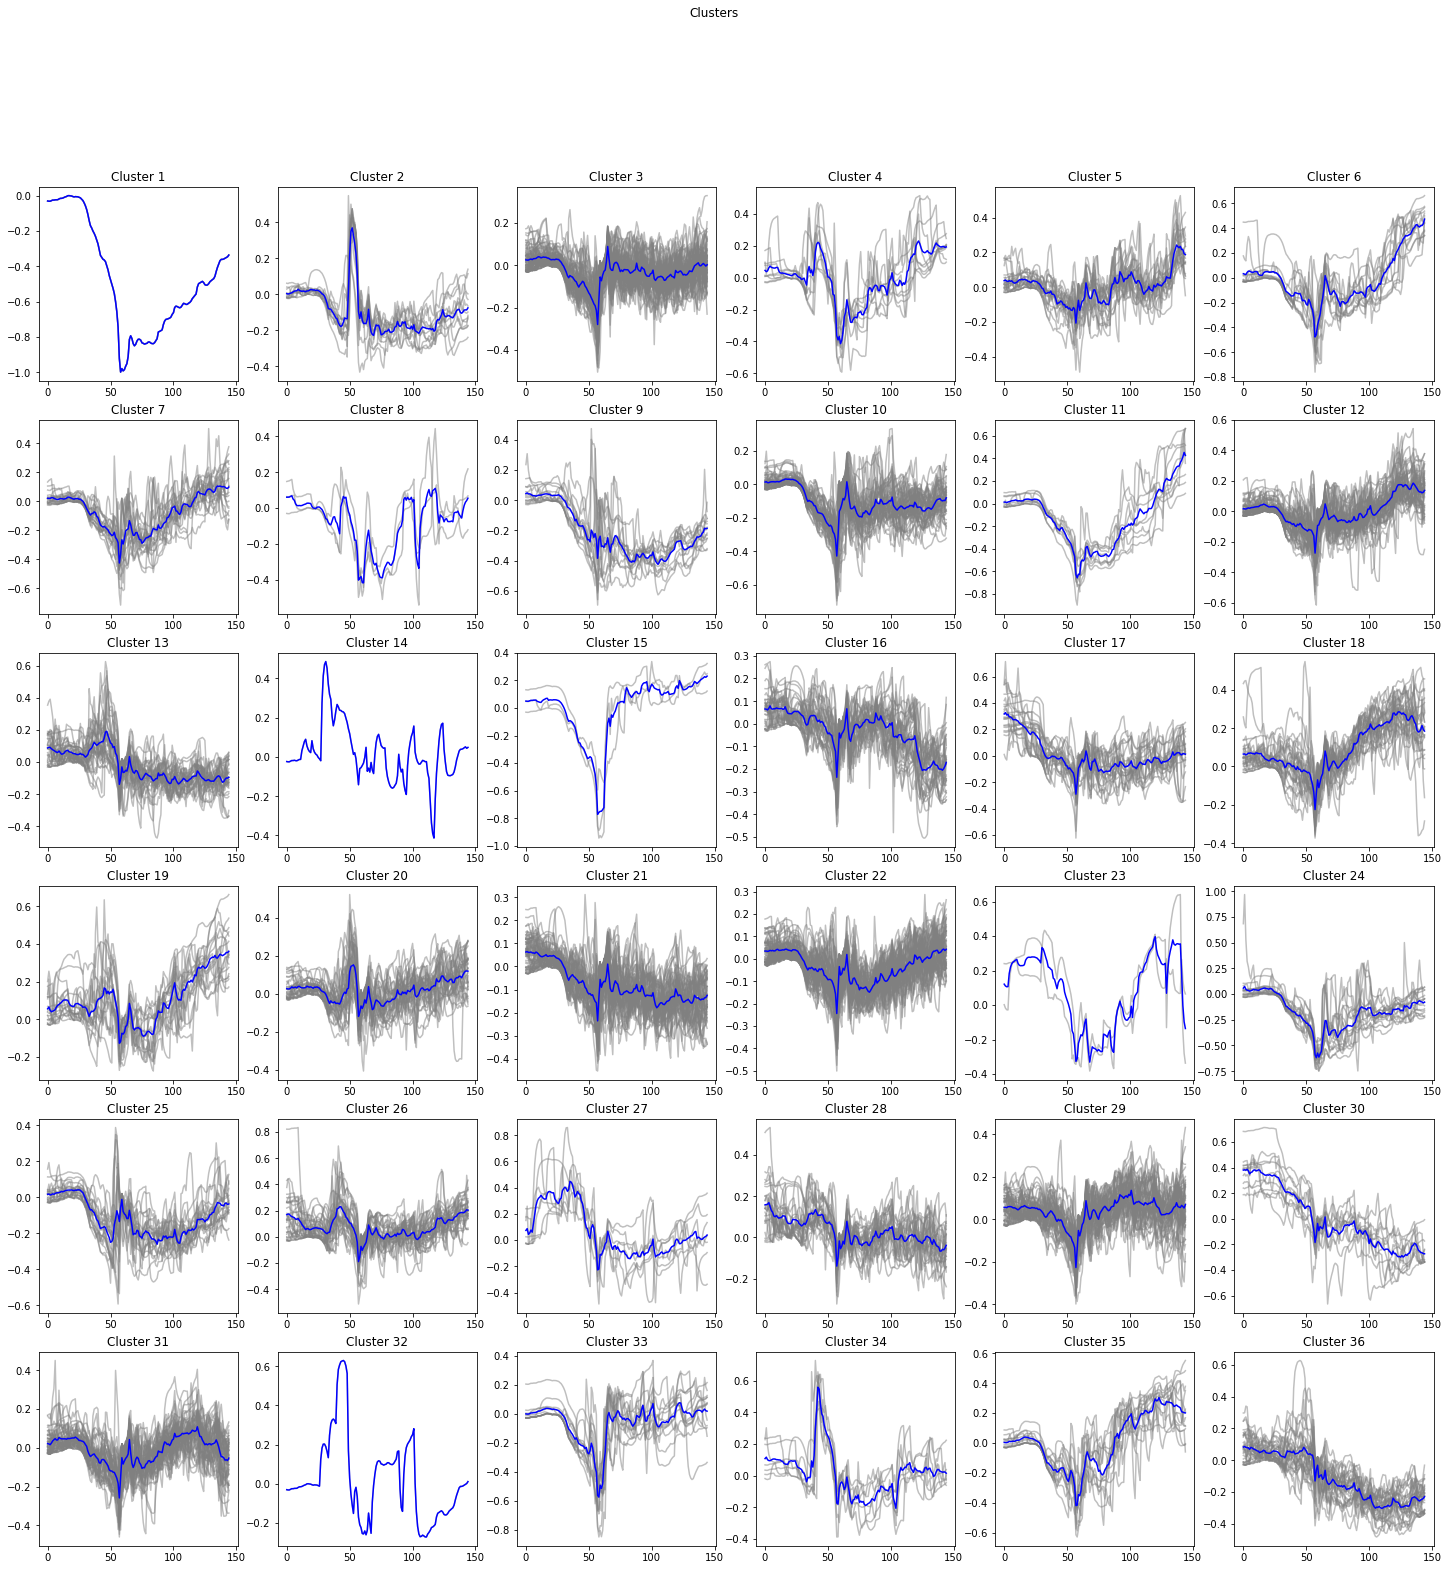

In [95]:
win_map = som.win_map(array_price_smooth05_scaled_sub_t)

plot_som_series_averaged_center_without_index(som_x, som_y, win_map)

In [98]:
cluster_map = []
for idx in range(len(array_price_smooth05_scaled_sub_t)):
    winner_node = som.winner(array_price_smooth05_scaled_t[idx])
    cluster_map.append((list_price_droped[idx],f"Cluster {winner_node[0]*som_y+winner_node[1]+1}"))

df_cluster = pd.DataFrame(cluster_map,columns=["Series","Cluster"]).sort_values(by="Cluster").set_index("Series")

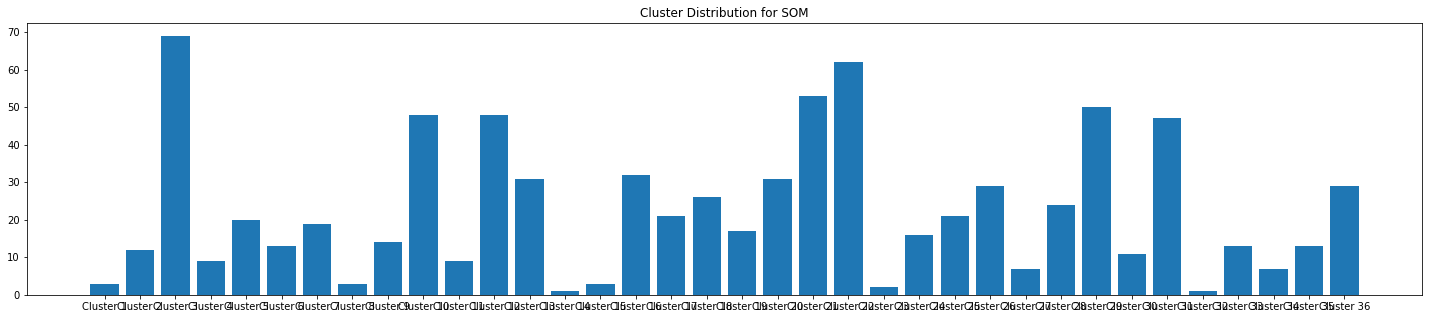

In [99]:
cluster_c = []
cluster_n = []
for x in range(som_x):
    for y in range(som_y):
        cluster = (x,y)
        if cluster in win_map.keys():
            cluster_c.append(len(win_map[cluster]))
        else:
            cluster_c.append(0)
        cluster_number = x*som_y+y+1
        cluster_n.append(f"Cluster {cluster_number}")

plt.figure(figsize=(25,5))
plt.title("Cluster Distribution for SOM")
plt.bar(cluster_n,cluster_c)
plt.show()

## 2. Dynamic Time Warping(DTW)

In [ ]:
n_clusters = 36
km_dba = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=300, max_iter_barycenter=100, random_state=0,
                          n_init=30).fit(array_price_smooth05_scaled_sub_t)
km_dba.cluster_centers_.shape
dtw_x = dtw_y = math.ceil(math.sqrt(n_clusters))
dtw_n = [(x, y) for x in range(dtw_x) for y in range(dtw_y)][:n_clusters]

df_cluster_dtw = pd.DataFrame(km_dba.labels_)
df_cluster_dtw.to_pickle("../storage/df_cluster_dtw.pkl")

In [ ]:
fig, axs = plt.subplots(dtw_x, dtw_y, figsize=(25, 25))
fig.suptitle('Clusters')

for cluster_n, dtw_cluster in zip(range(n_clusters), dtw_n):
    index_cluster = np.where(km_dba.labels_ == cluster_n)
    array_cluster = array_price_smooth05_scaled_sub_t[index_cluster]
    for index, subValue in enumerate(array_cluster):
        axs[dtw_cluster].plot(subValue, c="gray", alpha=0.5)
    axs[dtw_cluster].plot(np.average(np.vstack(array_cluster), axis=0), c="blue")
    cluster_number = dtw_cluster[0] * dtw_y + dtw_cluster[1] + 1
    axs[dtw_cluster].set_title(f"Cluster {cluster_number}")

plt.show()

In [ ]:
conn = DbEnv().connect_mongo('music_cow', 'daily_music_cow')

df_cluster_dtw = pd.read_pickle("../storage/df_cluster_dtw.pkl")

for cl_n in range(n_clusters):
    index_cl_n = [df_cluster_dtw == cl_n][0].values.tolist()
    list_cl_n = [list_price_droped[idx] * val[0] for idx, val in enumerate(index_cl_n) if val[0]==True]
    print('%s 번 클러스터' % cl_n)
    for cl in list_cl_n:
        list_song = conn.find({'num': int(cl)})
        for x in list_song:
            print('title:', x['song_title'], '---', 'artist:', x['song_artist'])